tensorspace.org https://tensorspace.org/html/playground/resnet50.html

Places Demo http://places2.csail.mit.edu/demo.html

# Grad-CAM
https://github.com/ismailuddin/gradcam-tensorflow-2

In [1]:
%matplotlib inline

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2


import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import cv2

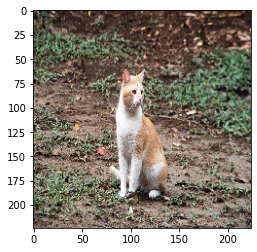

In [3]:
# 可以上傳其他測試圖片至data目錄下

image = np.array(load_img("./data/cat02.jpg", target_size=(224, 224, 3)))
plt.imshow(image)

# 建立一個訓練好的ResNet50 模型

In [4]:
model = ResNet50()

In [5]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

找出最後一個捲積層的layer name

最後的池化層的layer name

In [6]:
last_conv_layer = model.get_layer("conv5_block3_out")
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

利用原本模型(model)最後一個捲積層(last_conv_layer)的輸出，建立一個新的模型，然後使用剩下的神經層來獲取最後的預測結果
 (ResNet只剩GlobalAveragePooling2 跟 Dense)

In [7]:
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ["avg_pool", "predictions"]:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

首先，輸入圖片後，取出圖片經過模型到最後一個卷積層厚的書出，然後，我們要求tf觀看此張量輸出，為了計算出目標類別相對於該模型（最後一個卷積層模型）的預測的梯度。

In [8]:
#grad-cam

def grad_cam(classifier_model, image):
    with tf.GradientTape() as tape:
        inputs = image[np.newaxis, ...]
        last_conv_layer_output = last_conv_layer_model(inputs)    # 取影像輸入到model後，計算到最後一層的張量輸出
        tape.watch(last_conv_layer_output)    
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)    

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # Average over all the filters to get a single 2D array
    gradcam = np.mean(last_conv_layer_output, axis=-1)
    # Clip the values (equivalent to applying ReLU)
    # and then normalise the values
    gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
    gradcam = cv2.resize(gradcam, (224, 224))
    
    return gradcam


In [9]:
def superimpose(image, cam):
    """superimpose original image and cam heatmap"""
    
    heatmap = cv2.resize(cam, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * .5 + image * .5
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return image, heatmap, superimposed_img

In [10]:
def plot_heatmap(image, classifier_model):
    """plot original image, heatmap from cam and superimpose image"""

    img, heatmap, superimposed_img = superimpose(image, grad_cam(classifier_model, image))
    fig, axs = plt.subplots(ncols=3, figsize=(9, 4))

    axs[0].imshow(img)
    axs[0].set_title('original image')
    axs[0].axis('off')

    axs[1].imshow(heatmap)
    axs[1].set_title('heatmap')
    axs[1].axis('off')

    axs[2].imshow(superimposed_img)
    axs[2].set_title('superimposed image')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

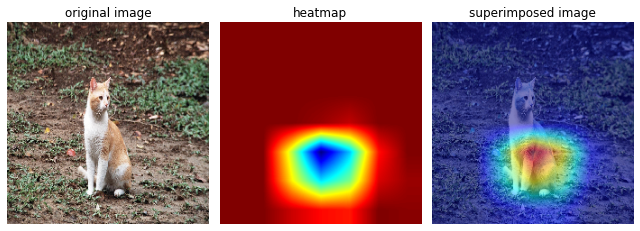

In [11]:
plot_heatmap(image, classifier_model)

In [12]:
decode_predictions(model.predict(image[np.newaxis, ...]))

[[('n02093859', 'Kerry_blue_terrier', 0.3046767),
  ('n01882714', 'koala', 0.14995477),
  ('n02120505', 'grey_fox', 0.06885835),
  ('n02120079', 'Arctic_fox', 0.06858395),
  ('n02106382', 'Bouvier_des_Flandres', 0.06230398)]]

# Counterfactual explanation

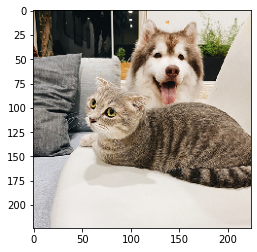

In [13]:
multiobject_image = np.array(
    load_img("./data/cat_and_dog.jpg", target_size=(224, 224, 3))
)
plt.imshow(multiobject_image)

In [14]:
#grad-cam

def grad_cam(classifier_model, image):
    with tf.GradientTape() as tape:
        inputs = image[np.newaxis, ...]
        last_conv_layer_output = last_conv_layer_model(inputs)    # 取影像輸入到model後，計算到最後一層的張量輸出
        tape.watch(last_conv_layer_output)    
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)    

    pooled_grads = tf.reduce_mean(-grads, axis=(0, 1, 2))    #反

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # Average over all the filters to get a single 2D array
    gradcam = np.mean(last_conv_layer_output, axis=-1)
    # Clip the values (equivalent to applying ReLU)
    # and then normalise the values
    gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
    gradcam = cv2.resize(gradcam, (224, 224))
    
    return gradcam


In [15]:
def superimpose(image, cam):
    """superimpose original image and cam heatmap"""
    
    heatmap = cv2.resize(cam, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * .5 + image * .5
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return image, heatmap, superimposed_img

In [16]:
def plot_heatmap(image, classifier_model):
    """plot original image, heatmap from cam and superimpose image"""

    img, heatmap, superimposed_img = superimpose(image, grad_cam(classifier_model, image))
    fig, axs = plt.subplots(ncols=3, figsize=(9, 4))

    axs[0].imshow(img)
    axs[0].set_title('original image')
    axs[0].axis('off')

    axs[1].imshow(heatmap)
    axs[1].set_title('heatmap')
    axs[1].axis('off')

    axs[2].imshow(superimposed_img)
    axs[2].set_title('superimposed image')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

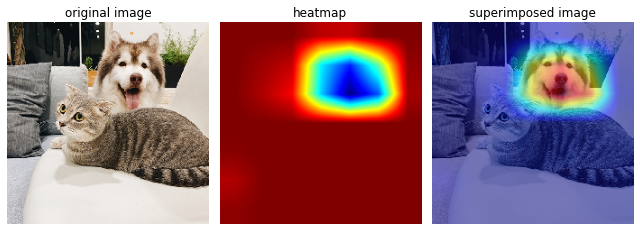

In [17]:
plot_heatmap(multiobject_image, classifier_model)

將狗遮住後重新預測，看會發生甚麼事情?

In [18]:
mask = grad_cam(classifier_model, multiobject_image)
mask[mask > 0.1] = 255
mask[mask != 255] = 0
mask = mask.astype(bool)

In [19]:
ctfctl_image = multiobject_image.copy()
ctfctl_image[mask] = (0, 0, 0)

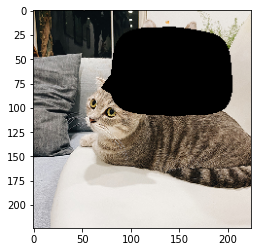

In [20]:
plt.imshow(ctfctl_image)

decode_predictions(model.predict(image[np.newaxis, ...]))

In [22]:
decode_predictions(model.predict(multiobject_image[np.newaxis, ...]))

[[('n02123045', 'tabby', 0.19494185),
  ('n02110063', 'malamute', 0.1538741),
  ('n02113624', 'toy_poodle', 0.075969785),
  ('n02113799', 'standard_poodle', 0.062479),
  ('n03938244', 'pillow', 0.04812213)]]

Egyptian_cat 的機率上升了

In [23]:
decode_predictions(model.predict(ctfctl_image[np.newaxis, ...]))

[[('n02124075', 'Egyptian_cat', 0.60261446),
  ('n02123045', 'tabby', 0.04000579),
  ('n04254777', 'sock', 0.036931053),
  ('n02834397', 'bib', 0.031778134),
  ('n03814639', 'neck_brace', 0.017811922)]]

---

# Guided Grad-CAM

The Grad-CAM output can be improved further by combining with guided backpropagation, which zeroes elements in the gradients which act negatively towards the decision. Implementation from Raphael Meudec / [Sicara](https://www.sicara.ai/blog/2019-08-28-interpretability-deep-learning-tensorflow), [GitHub Gist](https://gist.github.com/RaphaelMeudec/e9a805fa82880876f8d89766f0690b54).

This output, however, is still a low resolution heatmap, and not quite as described in the original paper. The original paper

In [24]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(image[np.newaxis, ...])
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [25]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)[0]
last_conv_layer_output = last_conv_layer_output[0]

Guided backpropagation implementation:

In [26]:
guided_grads = (
    tf.cast(last_conv_layer_output > 0, "float32")
    * tf.cast(grads > 0, "float32")
    * grads
)

In [27]:
pooled_guided_grads = tf.reduce_mean(guided_grads, axis=(0, 1))
guided_gradcam = np.ones(last_conv_layer_output.shape[:2], dtype=np.float32)

In [28]:
for i, w in enumerate(pooled_guided_grads):
    guided_gradcam += w * last_conv_layer_output[:, :, i]

In [29]:
guided_gradcam = cv2.resize(guided_gradcam.numpy(), (224, 224))

In [30]:
guided_gradcam = np.clip(guided_gradcam, 0, np.max(guided_gradcam))
guided_gradcam = (guided_gradcam - guided_gradcam.min()) / (
    guided_gradcam.max() - guided_gradcam.min()
)

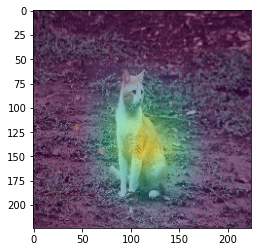

In [31]:
plt.imshow(image)
plt.imshow(guided_gradcam, alpha=0.5)

---

# Guided Grad-CAM (high resolution maps)
This approach reflects the paper's description better by first using the guided backpropagation approach to produce a high resolution map that is of the same resolution of the input image, which is then masked using the Grad-CAM heatmap to focus only on details that led to the prediction outcome. Based on the implementation on GitHub by [jacobgil](https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py).

In [32]:
@tf.custom_gradient
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy

    return tf.nn.relu(x), grad

In [33]:
class GuidedBackprop:
    def __init__(self, model, layer_name: str):
        self.model = model
        self.layer_name = layer_name
        self.gb_model = self.build_guided_model()

    def build_guided_model(self):
        gb_model = tf.keras.Model(
            self.model.inputs, self.model.get_layer(self.layer_name).output
        )
        layers = [
            layer for layer in gb_model.layers[1:] if hasattr(layer, "activation")
        ]
        for layer in layers:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guided_relu
        return gb_model

    def guided_backprop(self, image: np.ndarray):
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            tape.watch(inputs)
            outputs = self.gb_model(inputs)
        grads = tape.gradient(outputs, inputs)[0]
        return grads

In [34]:
gb = GuidedBackprop(model, "conv5_block3_out")

In [35]:
saliency_map = gb.guided_backprop(image[np.newaxis, ...]).numpy()
saliency_map = saliency_map * np.repeat(guided_gradcam[..., np.newaxis], 3, axis=2)

In [36]:
saliency_map -= saliency_map.mean()
saliency_map /= saliency_map.std() + tf.keras.backend.epsilon()
saliency_map *= 0.25
saliency_map += 0.5
saliency_map = np.clip(saliency_map, 0, 1)
saliency_map *= (2 ** 8) - 1
saliency_map = saliency_map.astype(np.uint8)

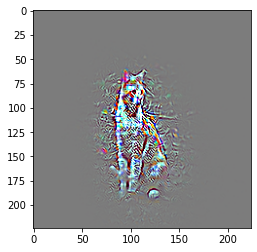

In [37]:
plt.imshow(saliency_map)